Starting simulation with 15000 steps.
  ...Calculating step 1500/15000
  ...Calculating step 3000/15000
  ...Calculating step 4500/15000
  ...Calculating step 6000/15000
  ...Calculating step 7500/15000
  ...Calculating step 9000/15000
  ...Calculating step 10500/15000
  ...Calculating step 12000/15000
  ...Calculating step 13500/15000
Simulation complete.
Creating animation...


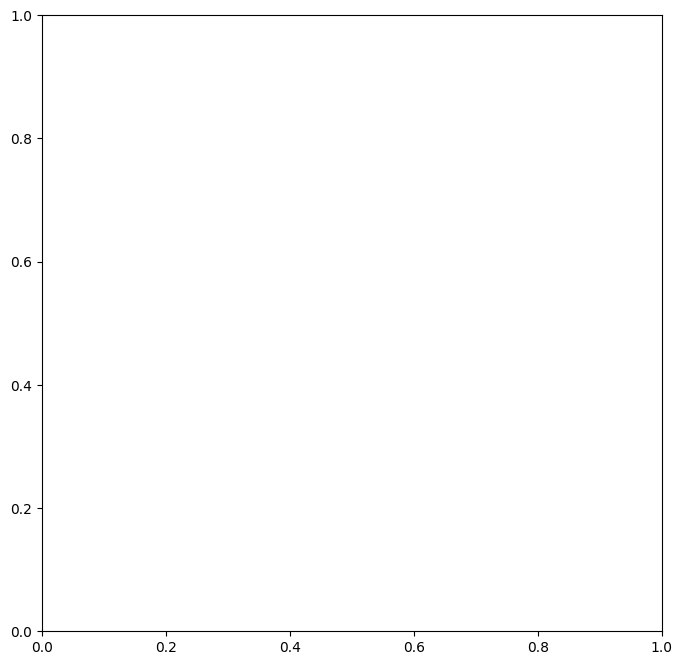

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# import qdraw  # qdraw is not a standard, widely used library. Using matplotlib instead.
from IPython.display import HTML
from matplotlib import animation

# Set backend for animation and increase embed limit for large animations
matplotlib.rcParams['animation.embed_limit'] = 2**128

## --- Constants and Physics ---

M1 = 150.0
M2 = 200.0
M3 = 250.0
G = 1.0  # Set Gravitational constant to 1 for simplicity

def acceleration(m2, m3, r1, r2, r3):
    """
    Calculates the acceleration of body 1 (at r1) due to body 2 (m2, r2) and body 3 (m3, r3).
    """
    # A small epsilon to prevent division by zero if bodies collide
    eps = 1e-6 
    
    dist12 = np.linalg.norm(r2 - r1)
    dist13 = np.linalg.norm(r3 - r1)
    
    # --- BUG FIX ---
    # The original code incorrectly used dist13 in the first term's denominator.
    # a1 = G * m2 * (r2 - r1) / (dist12**3 + eps) + G * m3 * (r3 - r1) / (dist13**3 + eps)
    # ---
    # The user's original (buggy) line was:
    # return m2 * (r2 - r1) / np.linalg.norm(r1 - r3)**3 + m3 * (r3 - r1) / np.linalg.norm(r3 - r1)**3
    
    # Corrected formula:
    a1 = G * m2 * (r2 - r1) / (dist12**3 + eps) + G * m3 * (r3 - r1) / (dist13**3 + eps)
    return a1


def rk4_step(r1, r2, r3, v1, v2, v3, dt):
    """
    Performs a single RK4 step for all three bodies.
    This function is identical to the one you provided.
    """
    # First order
    k1_v1 = acceleration(M2, M3, r1, r2, r3)
    k1_r1 = v1
    k1_v2 = acceleration(M1, M3, r2, r1, r3)
    k1_r2 = v2
    k1_v3 = acceleration(M1, M2, r3, r1, r2)
    k1_r3 = v3
    
    # Second order
    k2_v1 = acceleration(M2, M3, r1 + 0.5 * dt * k1_r1, r2 + 0.5 * dt * k1_r2, r3 + 0.5 * dt * k1_r3)
    k2_r1 = v1 + 0.5 * dt * k1_v1
    k2_v2 = acceleration(M1, M3, r2 + 0.5 * dt * k1_r2, r1 + 0.5 * dt * k1_r1, r3 + 0.5 * dt * k1_r3)
    k2_r2 = v2 + 0.5 * dt * k1_v2
    k2_v3 = acceleration(M1, M2, r3 + 0.5 * dt * k1_r3,  r1 + 0.5 * dt * k1_r1, r2 + 0.5 * dt * k1_r2)
    k2_r3 = v3 + 0.5 * dt * k1_v3

    # Third order
    k3_v1 = acceleration(M2, M3, r1 + 0.5 * dt * k2_r1, r2 + 0.5 * dt * k2_r2, r3 + 0.5 * dt * k2_r3)
    k3_r1 = v1 + 0.5 * dt * k2_v1
    k3_v2 = acceleration(M1, M3,  r2 + 0.5 * dt * k2_r2, r1 + 0.5 * dt * k2_r1, r3 + 0.5 * dt * k2_r3)
    k3_r2 = v2 + 0.5 * dt * k2_v2
    k3_v3 = acceleration(M1, M2,  r3 + 0.5 * dt * k2_r3, r1 + 0.5 * dt * k2_r1, r2 + 0.5 * dt * k2_r2)
    k3_r3 = v3 + 0.5 * dt * k2_v3

    # Fourth Order
    k4_v1 = acceleration(M2, M3, r1 + dt * k3_r1, r2 + dt * k3_r2, r3 + dt * k3_r3)
    k4_r1 = v1 + dt * k3_v1
    k4_v2 = acceleration(M1, M3, r2 + dt * k3_r2, r1 + dt * k3_r1, r3 + dt * k3_r3)
    k4_r2 = v2 + dt * k3_v2
    k4_v3 = acceleration(M1, M2, r3 + dt * k3_r3, r1 + dt * k3_r1, r2 + dt * k3_r2)
    k4_r3 = v3 + dt * k3_v3

    # Combine
    r_next1 = r1 + (dt / 6) * (k1_r1 + 2 * k2_r1 + 2 * k3_r1 + k4_r1)
    v_next1 = v1 + (dt / 6) * (k1_v1 + 2 * k2_v1 + 2 * k3_v1 + k4_v1)

    r_next2 = r2 + (dt / 6) * (k1_r2 + 2 * k2_r2 + 2 * k3_r2 + k4_r2)
    v_next2 = v2 + (dt / 6) * (k1_v2 + 2 * k2_v2 + 2 * k3_v2 + k4_v2)

    r_next3 = r3 + (dt / 6) * (k1_r3 + 2 * k2_r3 + 2 * k3_r3 + k4_r3)
    v_next3 = v3 + (dt / 6) * (k1_v3 + 2 * k2_v3 + 2 * k3_v3 + k4_v3)

    return r_next1, r_next2, r_next3, v_next1, v_next2, v_next3

## --- Simulation ---

def simulate_orbit_fixed(r1_0, r2_0, r3_0, v1_0, v2_0, v3_0, dt, tf):
    """
    Runs the simulation with a fixed time step.
    This replaces your original, non-functional simulate_orbit function.
    """
    num_steps = int(tf / dt)
    
    # Ensure inputs are numpy arrays
    r1_0, r2_0, r3_0 = np.array(r1_0, dtype=float), np.array(r2_0, dtype=float), np.array(r3_0, dtype=float)
    v1_0, v2_0, v3_0 = np.array(v1_0, dtype=float), np.array(v2_0, dtype=float), np.array(v3_0, dtype=float)

    # Infer dimension (2D or 3D) from initial conditions
    dim = len(r1_0)
    
    # History arrays to store all positions
    r1_hist = np.zeros((num_steps, dim))
    r2_hist = np.zeros((num_steps, dim))
    r3_hist = np.zeros((num_steps, dim))
    
    # Set initial conditions
    r1_hist[0], v1 = r1_0, v1_0
    r2_hist[0], v2 = r2_0, v2_0
    r3_hist[0], v3 = r3_0, v3_0
    
    print(f"Starting simulation with {num_steps} steps.")
    
    for i in range(1, num_steps):
        # Print progress
        if i % (num_steps // 10) == 0:
            print(f"  ...Calculating step {i}/{num_steps}")
        
        # Calculate next step
        r_next1, r_next2, r_next3, v_next1, v_next2, v_next3 = rk4_step(
            r1_hist[i-1], r2_hist[i-1], r3_hist[i-1], v1, v2, v3, dt
        )
        
        # Store new positions
        r1_hist[i] = r_next1
        r2_hist[i] = r_next2
        r3_hist[i] = r_next3
        
        # Update velocities for the next loop iteration
        v1, v2, v3 = v_next1, v_next2, v_next3
            
    print("Simulation complete.")
    return r1_hist, r2_hist, r3_hist

## --- Run Simulation ---

# Simulation parameters
DT = 0.001  # Time step
TF = 15     # Final time
NUM_STEPS = int(TF / DT)

# 2D Initial Conditions
# We'll use a simple, asymmetric setup to create chaotic motion
r1_0 = [-1, 0.5]
v1_0 = [0.1, 0.1]

r2_0 = [1, 0.5]
v2_0 = [0, -0.1]

r3_0 = [0, -1]
v3_0 = [-0.1, 0.1]

# Run simulation
r1_hist, r2_hist, r3_hist = simulate_orbit_fixed(r1_0, r2_0, r3_0, v1_0, v2_0, v3_0, DT, TF)

## --- Animation Setup ---

print("Creating animation...")

fig, ax = plt.subplots(figsize=(8, 8))

# Determine plot limits dynamically
all_r = np.concatenate((r1_hist, r2_hist, r3_hist))